### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3,
    "V_g_profile":False,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



In [4]:
# # Create a dict with all important settings

# data_vessel = {
#     "env": None,
#     "name": 'Vessel M6',
#     "route": None,
#     "geometry": None,
#     "v": None,  # m/s
#     "V_g_ave":3,
#     "V_g_profile":False,
#     "type": None,
#     "B": 10.5,
#     "L": 155.75,
#     "H_e": None, 
#     "H_f": None, 
#     "T": 2,
#     "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
#     "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
#     "payload":None,
#     "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
#     "P_installed": 780.0,   
#     "P_tot_given": None, # kW
#     "P_tot_given_profile":False,
#     "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
#     "sailing_on_power": False,
#     "sailing_upstream":False,
#     "wind_influence": False,
#     "P_hotel_perc": 0,
#     "P_hotel": None, # None: calculate P_hotel from percentage
#     "x": 1,# number of propellers
#     "L_w": 2.0 ,
#     "C_B":0.85, 
#     "C_year": 1961,
# }             



In [5]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [6]:
V_s = np.linspace(3/3.6, 20/3.6, 86)          # ship sailing speeds to water, (m/s)
# V_s_km_h =  np.linspace(3,20,35)

h_0 = [3,3.3,4.2,5,5.5,8,10.6,20]                 # water depths,(m)
T = [2]   # draught


### prepare input matrix for calculation

In [7]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(T, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,T,h_0,V_s
683,2,20.0,5.333333
684,2,20.0,5.388889
685,2,20.0,5.444444
686,2,20.0,5.500000
687,2,20.0,5.555556


### Run OpenTNSim to Calculate resistance, required power and emissions 

In [8]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    
    data_vessel_i = data_vessel.copy()
    
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T']
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    # h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    # print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    (eta_D, P_propulsion,P_tot,P_given) = vessel.calculate_total_power_required(V_s, h_0)

    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f'] = R_f
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['eta_D'] = eta_D
    result['P_d'] = P_propulsion

    results.append(result)

688it [00:00, 1302.76it/s]


In [9]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head(50)

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,eta_D,P_d,V_s_km
0,2.0,3.0,0.833333,780.0,0.861739,1.058037,0.107717,2.582259e-13,0.306899,1.472653,0.55,2.231292,3.0
1,2.0,3.0,0.888889,780.0,0.969870,1.190799,0.121234,2.298796e-12,0.349244,1.661277,0.55,2.684892,3.2
2,2.0,3.0,0.944444,780.0,1.083832,1.330721,0.135479,1.604277e-11,0.394364,1.860564,0.55,3.194908,3.4
3,2.0,3.0,1.000000,780.0,1.203575,1.477740,0.150447,9.128932e-11,0.442272,2.070459,0.55,3.764471,3.6
4,2.0,3.0,1.055556,780.0,1.329051,1.631799,0.166131,4.370085e-10,0.492982,2.290912,0.55,4.396700,3.8
5,2.0,3.0,1.111111,780.0,1.460217,1.792844,0.182527,1.804695e-09,0.546509,2.521880,0.55,5.094708,4.0
6,2.0,3.0,1.166667,780.0,1.597032,1.960824,0.199629,6.562130e-09,0.602871,2.763324,0.55,5.861596,4.2
7,2.0,3.0,1.222222,780.0,1.739456,2.135692,0.217432,2.136570e-08,0.662085,3.015209,0.55,6.700464,4.4
8,2.0,3.0,1.277778,780.0,1.887454,2.317402,0.235932,6.316608e-08,0.724171,3.277505,0.55,7.614406,4.6
9,2.0,3.0,1.333333,780.0,2.040991,2.505914,0.255124,1.715619e-07,0.789149,3.550187,0.55,8.606514,4.8


In [10]:
plot_df.tail(50)

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,eta_D,P_d,V_s_km
638,2.0,20.0,2.833333,780.0,7.291976,8.953034,0.911497,0.021923,3.135059,13.021513,0.55,67.080521,10.2
639,2.0,20.0,2.888889,780.0,7.560144,9.282289,0.945018,0.027362,3.250331,13.505000,0.55,70.935354,10.4
640,2.0,20.0,2.944444,780.0,7.832815,9.617072,0.979102,0.033880,3.367323,13.997378,0.55,74.935457,10.6
641,2.0,20.0,3.000000,780.0,8.109977,9.957370,1.013747,0.041637,3.486018,14.498772,0.55,79.084209,10.8
642,2.0,20.0,3.055556,780.0,8.391620,10.303169,1.048952,0.050806,3.606394,15.009322,0.55,83.385122,11.0
643,2.0,20.0,3.111111,780.0,8.677735,10.654459,1.084717,0.061576,3.728433,15.529185,0.55,87.841853,11.2
644,2.0,20.0,3.166667,780.0,8.968311,11.011226,1.121039,0.074152,3.852114,16.058531,0.55,92.458209,11.4
645,2.0,20.0,3.222222,780.0,9.263339,11.373460,1.157917,0.088755,3.977417,16.597549,0.55,97.238168,11.6
646,2.0,20.0,3.277778,780.0,9.562809,11.741147,1.195351,0.105620,4.104324,17.146443,0.55,102.185870,11.8
647,2.0,20.0,3.333333,780.0,9.866713,12.114278,1.233339,0.124996,4.232814,17.705427,0.55,107.305621,12.0


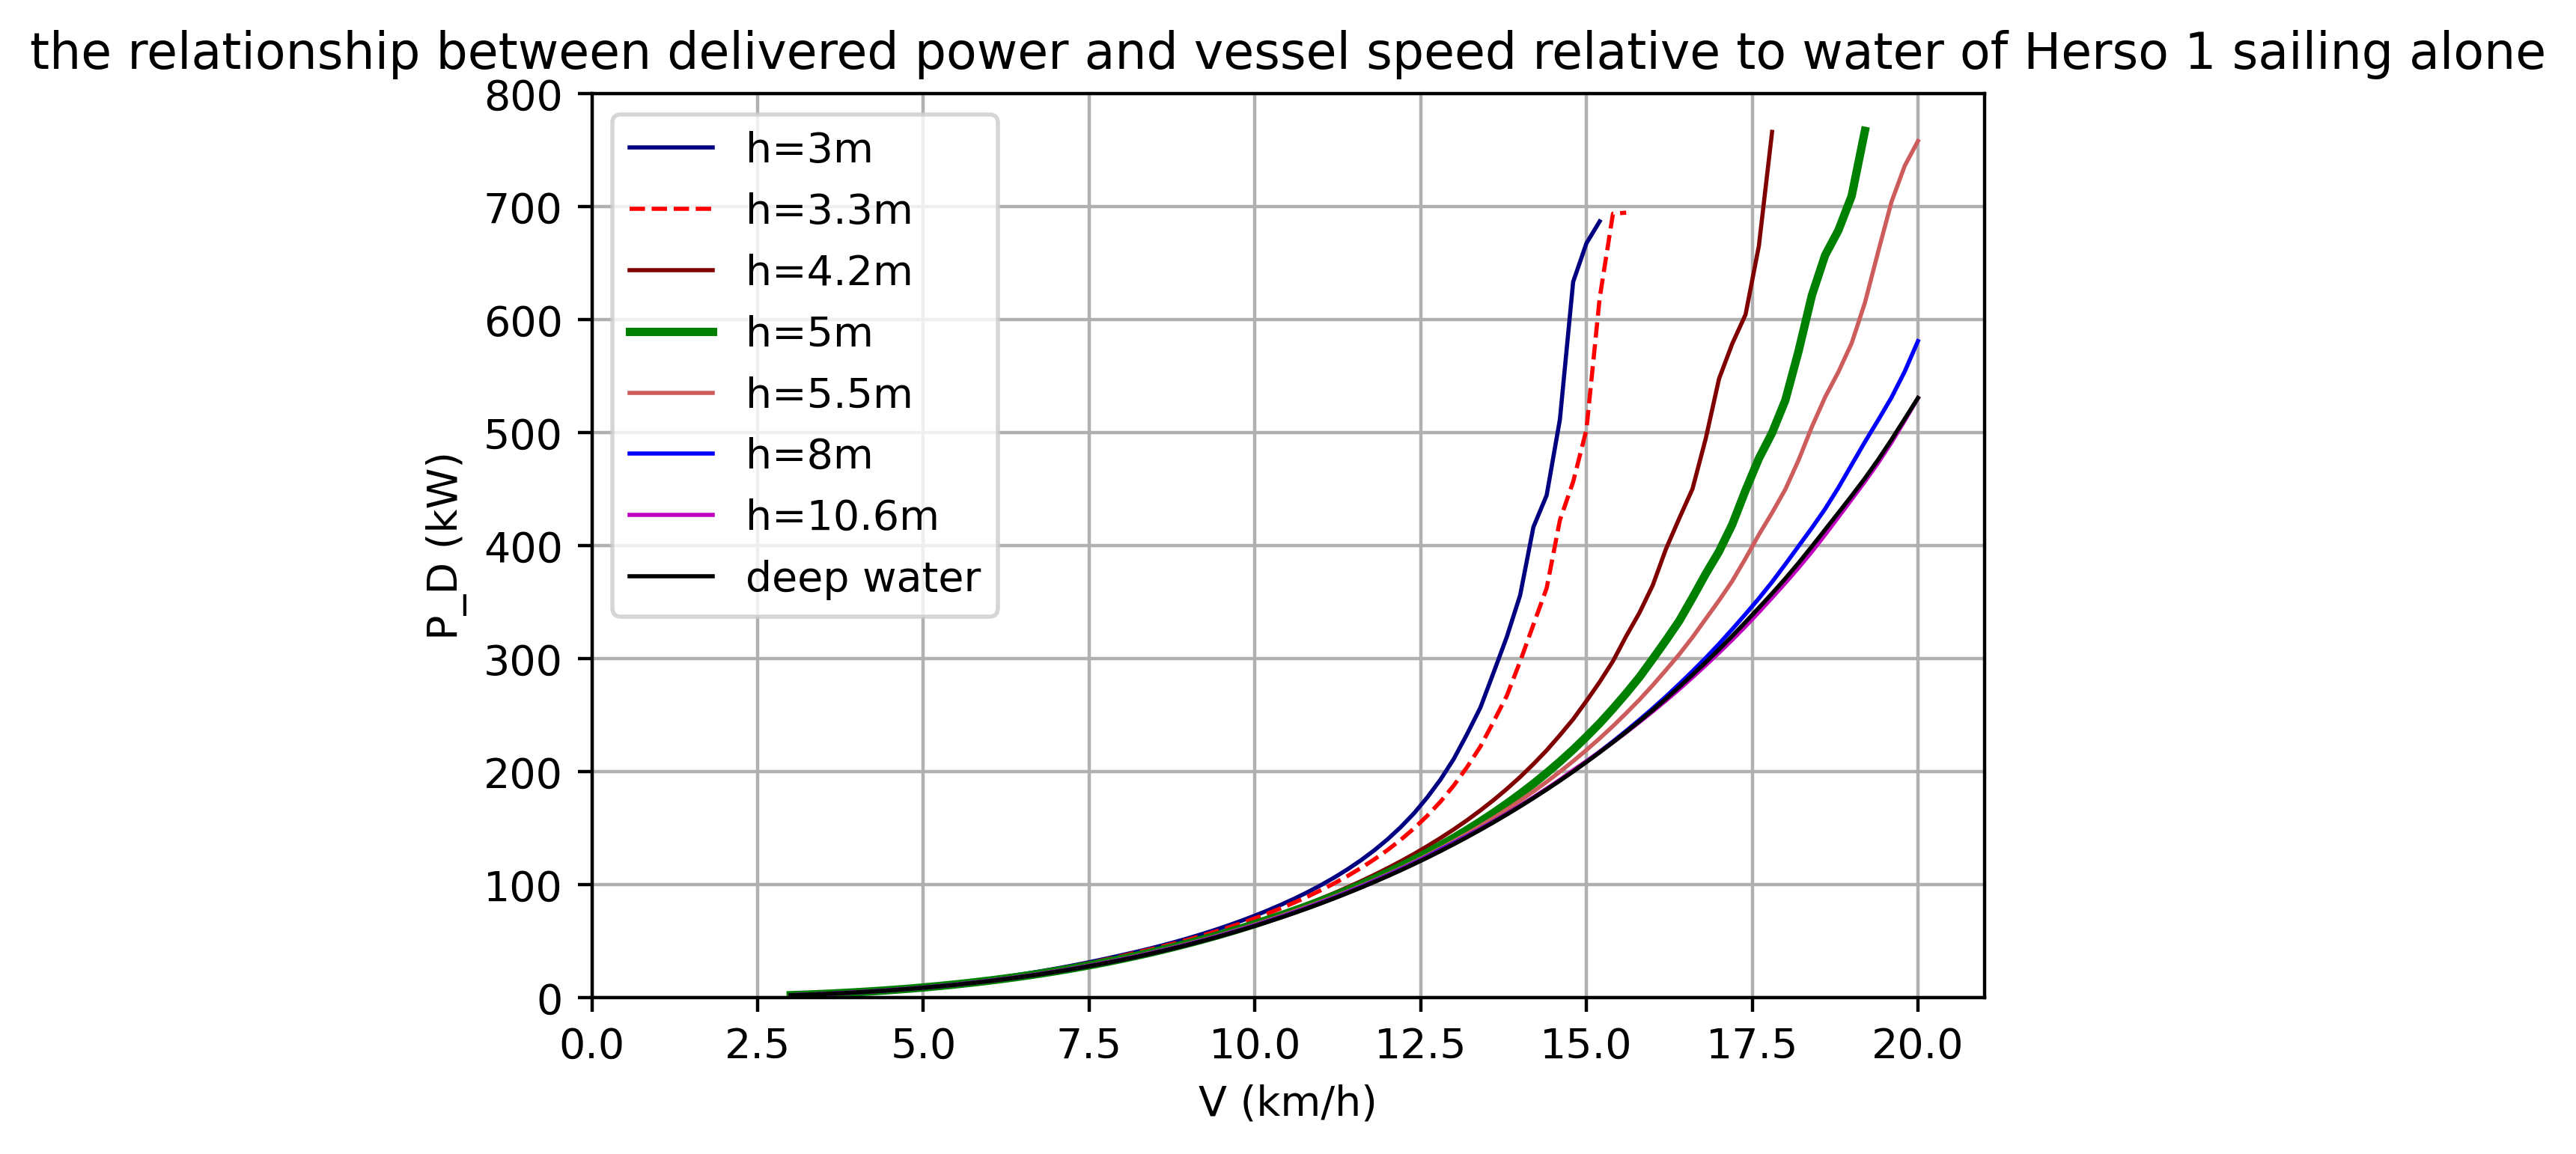

In [11]:
selected_h_3 = plot_df.query('h_0 == 3 & P_d < P_installed')
selected_h_3_3 = plot_df.query('h_0 == 3.3 & P_d < P_installed')
selected_h_4_2 = plot_df.query('h_0 == 4.2 & P_d < P_installed')
selected_h_5 = plot_df.query('h_0 == 5 & P_d < P_installed')
selected_h_5_5 = plot_df.query('h_0 == 5.5 & P_d < P_installed')
selected_h_8 = plot_df.query('h_0 == 8 & P_d < P_installed')
selected_h_10_6 = plot_df.query('h_0 == 10.6 & P_d < P_installed')
selected_h_deep = plot_df.query('h_0 == 20 & P_d < P_installed')
plt.figure(dpi=400)
plt.plot(selected_h_3['V_s_km'],selected_h_3['P_d'], 'navy', linewidth = 1.0)
plt.plot(selected_h_3_3['V_s_km'],selected_h_3_3['P_d'], 'r', linewidth = 1.0, linestyle = 'dashed')
plt.plot(selected_h_4_2['V_s_km'],selected_h_4_2['P_d'], 'maroon', linewidth = 1.0)
plt.plot(selected_h_5['V_s_km'],selected_h_5['P_d'], 'g', linewidth = 2.0)
plt.plot(selected_h_5_5['V_s_km'],selected_h_5_5['P_d'], 'indianred', linewidth = 1)
plt.plot(selected_h_8['V_s_km'],selected_h_8['P_d'], 'b', linewidth = 1.0)
plt.plot(selected_h_10_6['V_s_km'],selected_h_10_6['P_d'], 'm', linewidth = 1.0)
plt.plot(selected_h_deep['V_s_km'],selected_h_deep['P_d'], 'k', linewidth = 1)

plt.xlabel('V (km/h)')
plt.ylabel('P_D (kW)')
plt.legend(['h=3m','h=3.3m','h=4.2m','h=5m','h=5.5m','h=8m','h=10.6m','deep water'])
plt.grid()
plt.xlim(0, 21)
plt.ylim(0,800)
plt.title('the relationship between delivered power and vessel speed relative to water of Herso 1 sailing alone');

In [12]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)


In [13]:
R=vessel.calculate_total_resistance(v=4, h_0=5)
P = vessel.calculate_total_power_required(v=4, h_0=5)
P

(0.55, 198.68745902900523, 198.68745902900523, 198.68745902900523)

In [14]:
V_w1 = opentnsim.strategy.power2v(vessel, h_0=5,power_applied=585, upperbound=8)
V_w1

5.069783404791168